<a href="https://colab.research.google.com/github/HenryZumaeta/MDS_UNI/blob/Zeta/CICLO02/MLNS/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Gaussian Mixture Models

Adaptado de: https://github.com/ageron/handson-ml2.

Exploraremos diferentes datasets con distribuciones de origen gaussiano para experimentar con el algoritmo GMM.

Vamos a recordar cómo funciona primero el k-means, en qué se parece al GMM y por qué podemos considerar el GMM como una generalización más potente del k-means.

Empezamos, como siempre, con los imports necesarios:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
import seaborn as sns; sns.set()
import numpy as np

### Las debilidades del k-Means

Está claro que el k-means es un algoritmo muy utilizado dentro del clustering, pero tiene sus debilidades.

Vamos a entenderlas mediante dos ejemplos.

Antes de nada, vamos a generar los datos para ambos ejemplos y a visualizarlos. Simplemente vamos a usar un dataset artificialmente generado con 2 centros, y luego vamos a "estirar" dicho dataset:

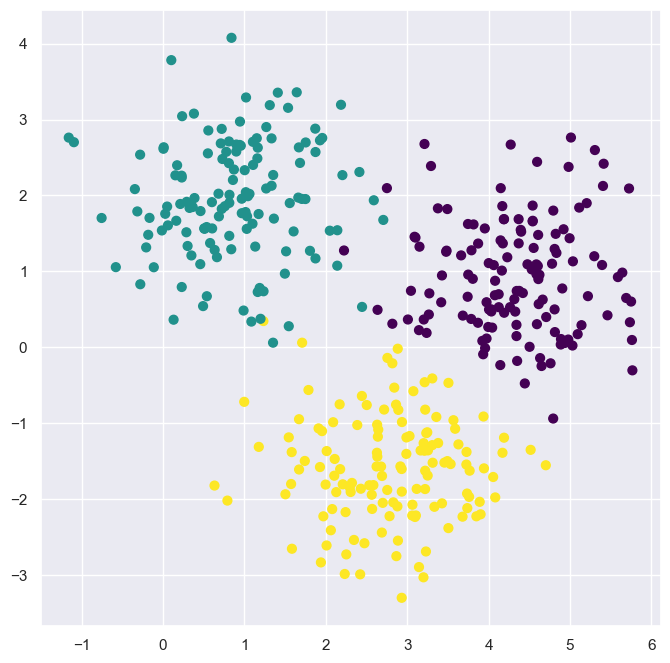

In [ ]:
# generamos nuestro dataset original
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=3,
                       cluster_std=0.75, random_state=0)
X = X[:, ::-1] # flip axes for better plotting
# mostramos los datos originales
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=40, cmap='viridis');

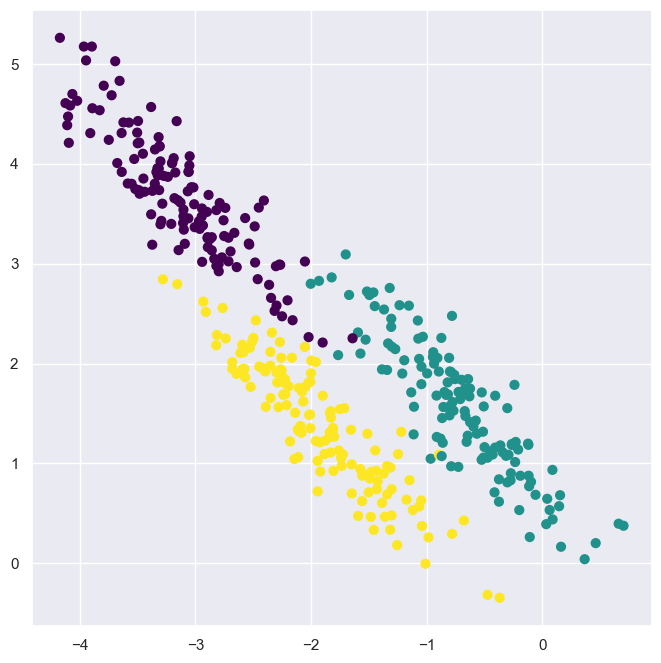

In [ ]:
# estiramos los datos
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
# mostramos los datos
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=y_true, s=40, cmap='viridis');

Ahora vamos a aplicar el mismo K-means exactamente sobre cada uno de ellos y observar los resultados.

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None, title=''):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

    ax.scatter(centers[:, 0], centers[:, 1], marker='*', c='w', s=300, zorder=3)
    ax.set_title(title)

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarnin

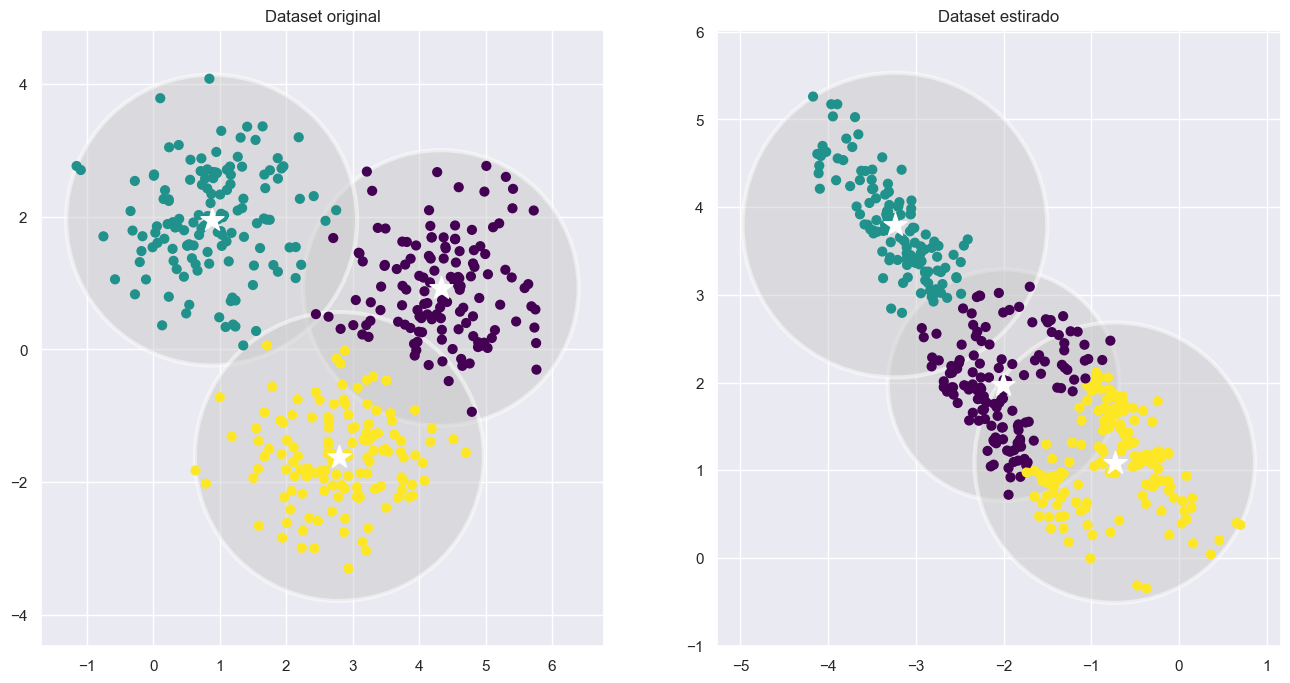

In [ ]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots(1,2)

kmeans = KMeans(n_clusters=3)
plot_kmeans(kmeans, X, ax=ax[0], title='Dataset original')
kmeans = KMeans(n_clusters=3)
plot_kmeans(kmeans, X_stretched, ax=ax[1], title='Dataset estirado')
plt.rcParams['figure.figsize'] = [8, 8]

Podemos observar varios problemas a simple vista:

- El k-means utiliza círculos (o en dimensions superiores, esferas o hiper-esferas) para delimitar los clusters, lo que muchas veces no se ajusta a la distribución real de nuestros datos. Esto es debido a la asunción de **independencia** entre las variables que usamos para clusterizar (covarianza es 0). Realmente el tamaño del cluster no es el círculo blanco, sino el punto medio entre centroides.

- El k-means no permite decidir el tamaño de estos círculos (hiper-esferas), este tamaño viene dado por la posición de los centroides de cada cluster. Con lo cual, en caso de tener clusters de tamaño dispar, el kmeans no va a poder clasificarlos correctamente.

- El k-means realiza asignaciones deterministas (hard-classification) de las muestras a los clusters, incluso cuando no está claro si pertenecen a uno u otro. Parece útil que si un elemento está entre dos clusters, en vez de asignarlo a uno u a otro, le asignemos un 50% de probabilidad de pertenecer a cada uno.

Todas estas limitaciones parecen bastante restrictivas, ¿verdad? ¿Y si encontraramos una generalización del k-means que solucionara estos problemas?

Pues si, los modelos de mezcla de gaussianas solucionan estos problemas!


## GMM

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

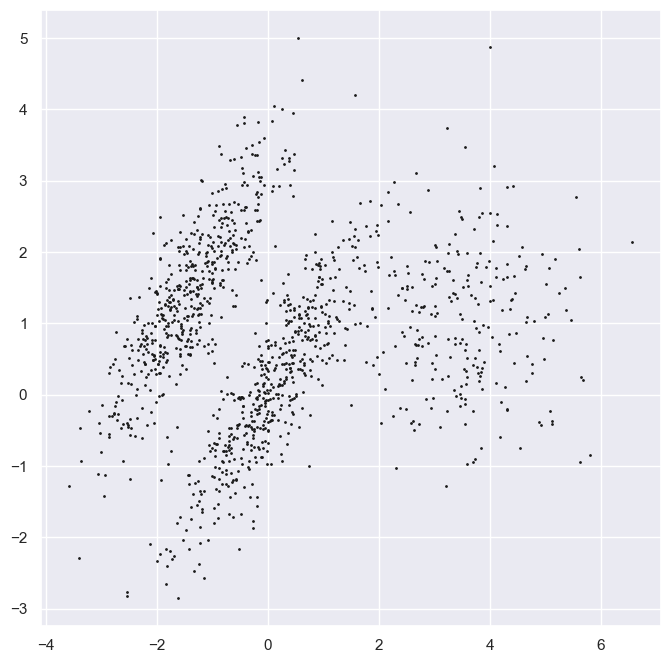

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

GaussianMixture(n_components=3, n_init=10, random_state=42)

Se puede utilizar el modelo para generar muestras nuevas de la distribución original.

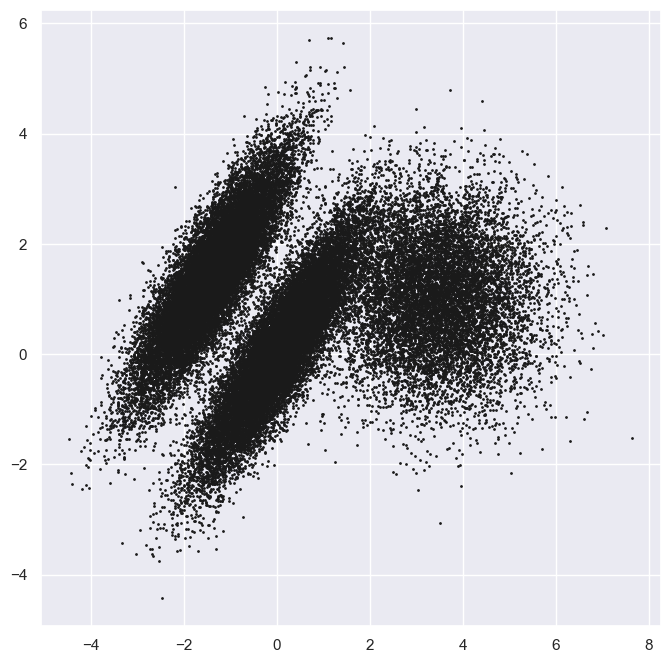

In [ ]:
X_new, y_new = gm.sample(50000)
plt.plot(X_new[:, 0], X_new[:, 1], 'k.', markersize=2)
plt.show()

**Pregunta:** ¿Qué particularidad se puede observar en el gráfico de las muestras generadas? Pruebe generar y graficar un mayor número de muestras.

Grafiquemos las fronteras de decisión y los contornos de densidad obtenidos por el modelo.

In [ ]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='w', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

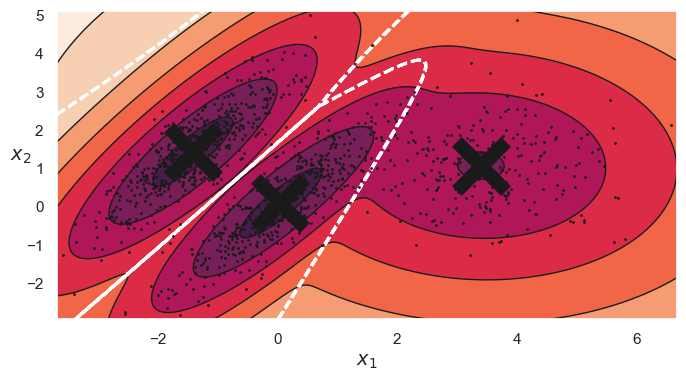

In [ ]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.show()

Como se vió en clase, es posible restringir las matrices de covarianza usando el parámetro covariance_type:

* "full" (por defecto): sin restricción, los clusters pueden tomar cualquier forma elipsoidal.
* "tied": los clusters deben tener la misma forma que puede ser cualquier elipsoide.
* "spherical": los clusters deben ser esféricos, solo varía el diámetro.
* "diag": los clusters pueden tener cualquier forma elipsoidal pero los ejes de la elipse deben ser paralelos a los ejes.

In [ ]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)

gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)

gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)

gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)

gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

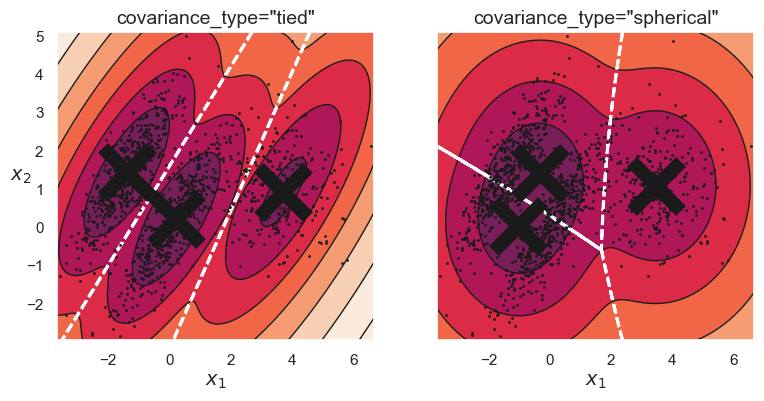

In [ ]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
plt.show()

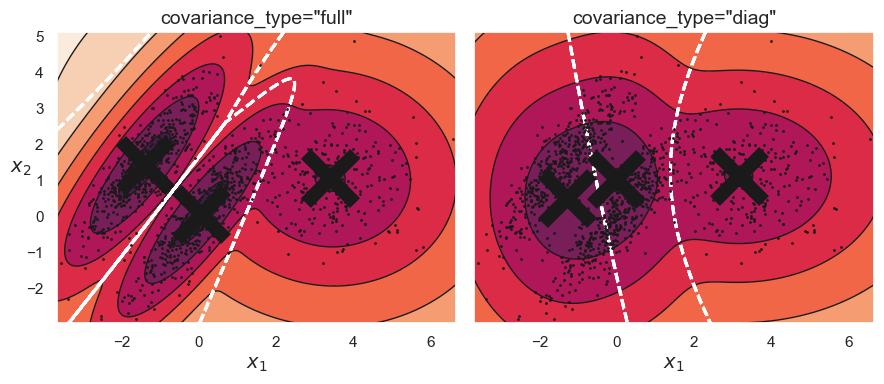

In [ ]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

### Detección de anomalías usando GMM


GMM puede usarse para detectar anomalías, basta explorar las instancias ubicadas en zonas de baja densidad. Se debe definir un límite de densidad para diferenciar una anomalía. Por ejemplo, si se conoce que 4% es la tasa de productos defectuosos en una fábrica, se puede usar como límite el valor de densidad que mantenga el 4% de instancias fuera.

In [ ]:
# Cálculo del límite de densidad que permite descartar el 4% de las instancias.
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

Podemos imprimir las anomalías respecto a las fronteras de decisión y los contornos de densidad obtenidos por el modelo.

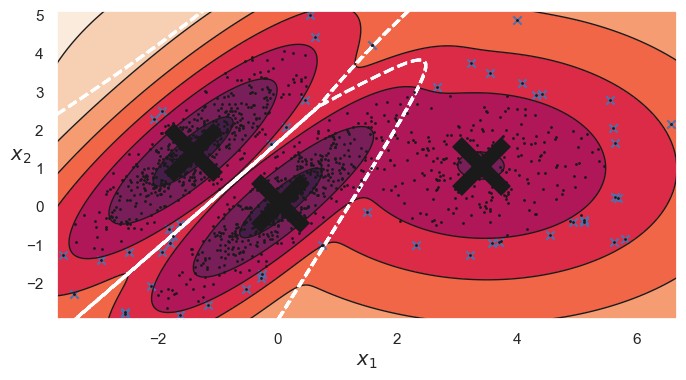

In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='b', marker='x')
plt.ylim(top=5.1)

plt.show()

**Pregunta :** ¿Cuántas instancias se utilizó? ¿Cuántas fueron detectadas como anomalías?

### GMM: Métricas de evaluación

Las métricas de evaluación revisadas para el algoritmo GMM son Bayesian information criterion (BIC) y Akaike information criterion (AIC). Se utilizarán estas métricas para detectar gráficamente el mejor valor de k para el conjunto de datos trabajado previamente. También se utilizará gridsearch para encontrar el mejor valor de k y covariance_type en base a la métrica BIC.

Entrenamiento de modelos GMM para k ∈ {1,2,3, ... ,11}

In [ ]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

Calculo de métricas BIC y AIC para cada modelo.

In [ ]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

Gráfica de los indicadores BIC y AIC para cada valor de k.

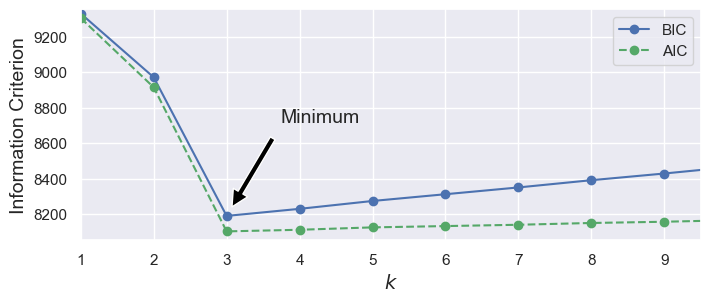

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

Se utiliza gridsearch para determinar el mejor valor de k y covariance_type.

In [ ]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

In [ ]:
best_k,best_covariance_type

(3, 'full')

### Bayesian Gaussian Mixture Model

En vez de realizar una búsqueda manual del número de clusters, se puede utilizar la clase BayesianGaussianMixture. Este modelo parte de un número inicial de componentes (que debe ser mayor al número de clusters) y asigna un peso de 0 a los componentes innecesarios. Podemos volver a experimentar con el conjunto de datos asumiendo que el número de componentes es menor a 10.

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\avaldiviac\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

Si revisamos los pesos del modelo, vemos que ha descartado 7 clusters, manteniendo solo 3.

In [ ]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.  , 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

Podemos graficar nuevamente las fronteras de decisión y los contornos de densidad obtenidos por el modelo.

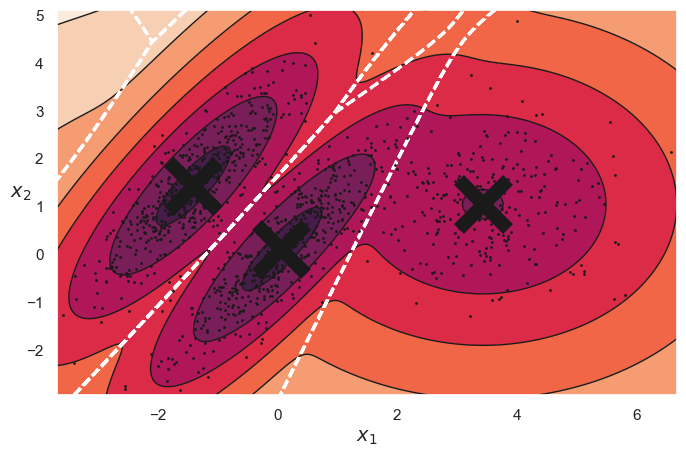

In [ ]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

## good job